### Load Dataset, Libraries

In [1]:
import keras
import numpy as np
import datetime
import tf_explain
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import Image, display, HTML
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train_normalized = (x_train / 127.5) - 1.0
x_test_normalized = (x_test / 127.5) - 1.0

print("x_train_normalized shape:", x_train_normalized.shape)
print("x_test_normalized shape:", x_test_normalized.shape)

2024-06-04 06:23:22.742203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 06:23:23.443875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


x_train_normalized shape: (60000, 28, 28)
x_test_normalized shape: (10000, 28, 28)


### Model

In [2]:
model = keras.models.Sequential([
  keras.layers.Conv2D(64, (5, 5),strides=(1, 1), padding='valid', activation='relu', dilation_rate=(1, 1), input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
  keras.layers.Conv2D(64, (5, 5),strides=(1, 1), padding='valid', activation='relu', dilation_rate=(1, 1)),
  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
  keras.layers.Flatten(),
  keras.layers.Dense(120, activation='relu'),
  keras.layers.Dense(84, activation='relu'),
  keras.layers.Dense(10, activation='softmax')])


2024-06-04 06:23:26.430820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 06:23:26.460392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 06:23:26.462091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Model Architecture

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 120)               1

In [4]:
model.save('my_model.h5')
model = keras.models.load_model('my_model.h5')
tf.saved_model.save(model, 'saved_model')
model_proto = 'saved_model/saved_model.pb'

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [5]:
import model_explorer

model_explorer.visualize('saved_model/saved_model.pb')

Loading extensions...
Loaded 8 extensions:
 - TFLite adapter (Flatbuffer)
 - TFLite adapter (MLIR)
 - TF adapter (MLIR)
 - TF adapter (direct)
 - GraphDef adapter
 - Pytorch adapter (exported program)
 - MLIR adapter
 - JSON adapter

Starting Model Explorer server at:
http://localhost:8080/?data=%7B%22models%22%3A%20%5B%7B%22url%22%3A%20%22/home/sami-yusuf-turan/AI/ComputerVision/Models/saved_model/saved_model.pb%22%7D%5D%7D

Press Ctrl+C to stop.


Stopping server...


In [6]:
def plot_model_architecture(base_model, model_name):
    plot_model(base_model, show_shapes=True, to_file=model_name)
    display(HTML('<img src="{}" style="display:inline;margin:1px"/>'.format(model_name)))

plot_model_architecture(model, 'model_mimari.png')

### Callbacks

In [29]:
rm -rf logs/fit/*

In [30]:
images = x_test[5:6]
labels = y_test[5:6]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
callbacks = [
tf_explain.callbacks.GradCAMCallback(validation_data=(images, labels), class_index=None, layer_name='conv2d_1', output_dir=log_dir),
tf_explain.callbacks.ActivationsVisualizationCallback(validation_data=(images, labels), layers_name=['conv2d_1'], output_dir=log_dir)
]

### Compile, Fit

In [32]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(x_train_normalized, y_train, validation_data=(x_test_normalized, y_test), epochs=10, batch_size=64, verbose=1, 
                    callbacks=[tensorboard_callback, callbacks])

Epoch 1/10
938/938 [==============================] - 5s 4ms/step - loss: 0.1071 - accuracy: 0.9596 - val_loss: 0.3146 - val_accuracy: 0.9073
Epoch 2/10
 36/938 [>.............................] - ETA: 2s - loss: 0.0923 - accuracy: 0.9683

/home/sami-yusuf-turan/Desktop/enviroments/ai_env_1/lib/python3.11/site-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


938/938 [==============================] - 3s 4ms/step - loss: 0.0942 - accuracy: 0.9654 - val_loss: 0.3534 - val_accuracy: 0.9025
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0880 - accuracy: 0.9677 - val_loss: 0.3430 - val_accuracy: 0.9099
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0807 - accuracy: 0.9693 - val_loss: 0.3642 - val_accuracy: 0.9103
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0758 - accuracy: 0.9715 - val_loss: 0.3459 - val_accuracy: 0.9163
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0693 - accuracy: 0.9743 - val_loss: 0.3821 - val_accuracy: 0.9097
Epoch 7/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0632 - accuracy: 0.9763 - val_loss: 0.3953 - val_accuracy: 0.9101
Epoch 8/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0583 - accuracy: 0.9784 - val_loss: 0.3988 - val_accuracy: 0.9113
Epoch 9/10
938/93

### Model Evaluation

In [11]:
train_loss, train_acc = model.evaluate(x_train_normalized, y_train)
test_loss, test_acc = model.evaluate(x_test_normalized, y_test)

print(f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')
print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

313/313 [==============================] - 0s 1ms/step - loss: 0.2853 - accuracy: 0.9124
Train Loss: 0.097, Train Accuracy: 0.964
Test Loss: 0.285, Test Accuracy: 0.912


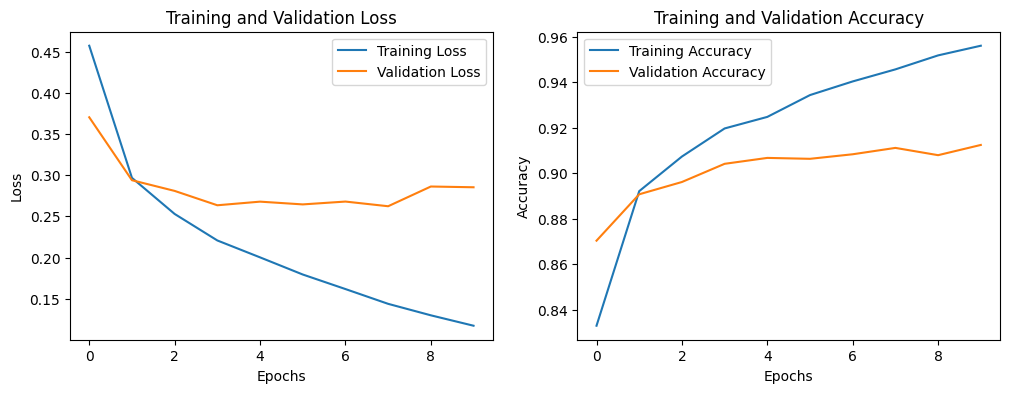

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

1/1 [==============================] - 0s 19ms/step


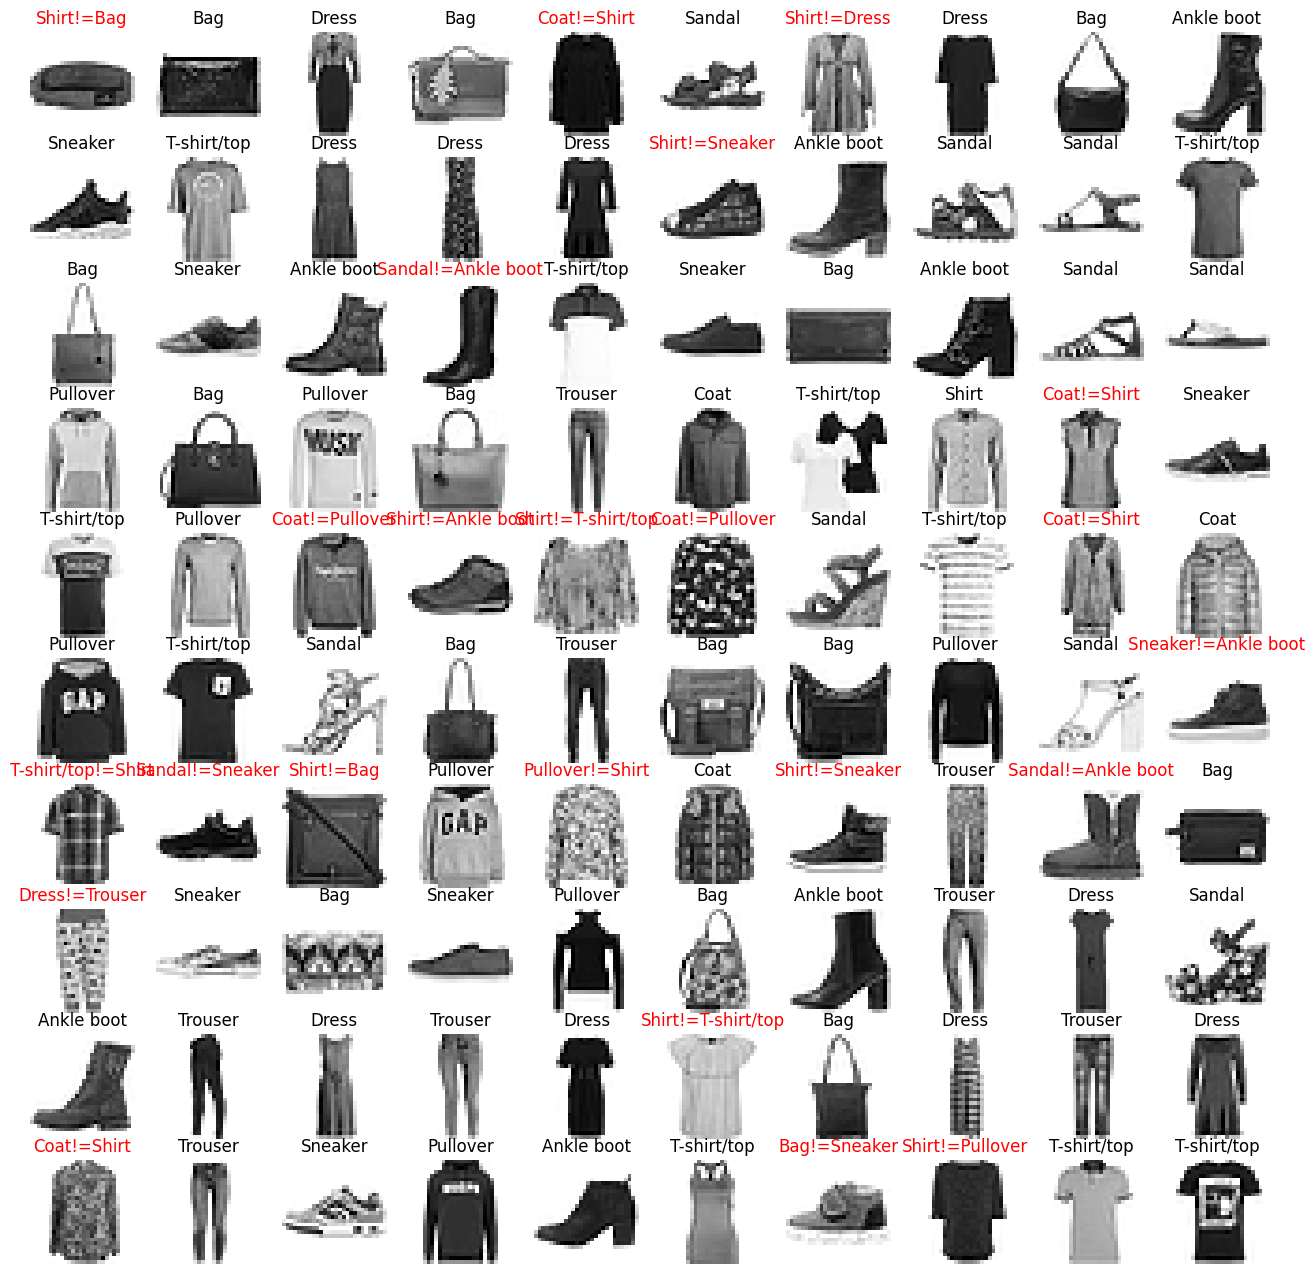

In [14]:
import random
from matplotlib import cm

def convertMnistData(image):
    img = image.astype('float32')
    img /= 255

    return image.reshape(1,28,28,1)

plt.figure(figsize=(16,16))

right = 0
mistake = 0
prefictionNum = 100

for i in range(prefictionNum):
    index = random.randint(0, x_test.shape[0])
    image = x_test[index]
    data = convertMnistData(image)

    plt.subplot(10, 10, i+1)
    plt.imshow(image,  cmap=cm.gray_r)
    plt.axis('off')

    ret = model.predict(data, batch_size=1) 

    bestnum = 0.0
    bestclass = 0
    for n in [0,1,2,3,4,5,6,7,8,9]:
        if bestnum < ret[0][n]:
            bestnum = ret[0][n]
            bestclass = n

    if y_test[index] == bestclass:
        plt.title(fashion_mnist_labels[bestclass])
        right += 1
    else:
        plt.title(fashion_mnist_labels[bestclass] + "!=" + fashion_mnist_labels[y_test[index]], color='#ff0000')
        mistake += 1
                                                                   
plt.show()

In [15]:
print("Doğru tahminlerin sayısı:", right)
print("Hata sayısı:", mistake)
print("Doğru tahmin oranı:", right/(mistake + right)*100, '%')

Doğru tahminlerin sayısı: 77
Hata sayısı: 23
Doğru tahmin oranı: 77.0 %


# ConvNet Interpretability

### TensorBoard with tf_explain

In [34]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 35208), started 0:01:19 ago. (Use '!kill 35208' to kill it.)

### Visualizing Filters

In [35]:
img_width = 28
img_height = 28
layer_name = "conv2d_1"

layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [36]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    print(f"Activation shape: {activation.shape}")
    filter_activation = activation[:, :, :, filter_index]
    return tf.reduce_mean(filter_activation)

In [37]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [38]:
def initialize_image():
    img = tf.random.uniform((1, img_width, img_height, 1))
    return (img - 0.5) * 0.25

In [39]:
def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    img += 0.5
    img = np.clip(img, 0, 1)

    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [40]:
def visualize_filter(filter_index):
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    img = deprocess_image(img[0].numpy())
    return loss, img

In [41]:
loss, img = visualize_filter(0)
keras.utils.save_img("0.png", img)

Activation shape: (1, 8, 8, 64)


In [42]:
display(Image("0.png"))

Processing filter 0
Processing filter 1
Activation shape: (1, 8, 8, 64)
Processing filter 2
Activation shape: (1, 8, 8, 64)
Processing filter 3


Activation shape: (1, 8, 8, 64)
Processing filter 4
Activation shape: (1, 8, 8, 64)
Processing filter 5
Activation shape: (1, 8, 8, 64)
Processing filter 6
Activation shape: (1, 8, 8, 64)
Processing filter 7
Activation shape: (1, 8, 8, 64)
Processing filter 8
Activation shape: (1, 8, 8, 64)
Processing filter 9
Activation shape: (1, 8, 8, 64)
Processing filter 10
Activation shape: (1, 8, 8, 64)
Processing filter 11
Activation shape: (1, 8, 8, 64)
Processing filter 12
Activation shape: (1, 8, 8, 64)
Processing filter 13
Activation shape: (1, 8, 8, 64)
Processing filter 14
Activation shape: (1, 8, 8, 64)
Processing filter 15
Activation shape: (1, 8, 8, 64)


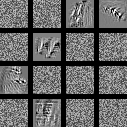

In [43]:
all_imgs = []
for filter_index in range(16):  
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

margin = 5
n = 4  
cropped_width = img_width
cropped_height = img_height
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.utils.save_img("stitched_filters.png", stitched_filters)

display(Image("stitched_filters.png"))

### Grad-CAM Class Activation Visualization

1/1 [==============================] - 0s 49ms/step


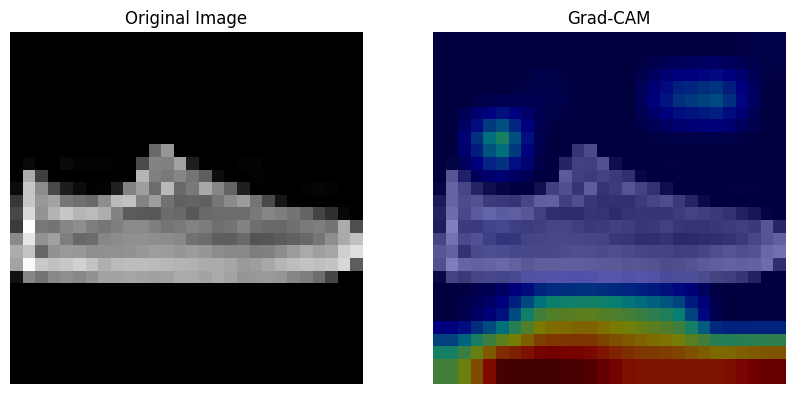

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Model
import cv2

last_conv_layer_name = "conv2d_1"  
classifier_layer_names = ["dense_2"]

grad_cam_model = Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.get_layer(classifier_layer_names[0]).output]
)

def grad_cam(input_model, image, cls, layer_name):
    img = np.expand_dims(image, axis=0)
    img = np.expand_dims(image, axis=0)

    with tf.GradientTape() as tape:
        last_conv_output, preds = input_model(img)
        class_out = preds[:, cls]
    
    grads = tape.gradient(class_out, last_conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

img_index = 12 
image = x_test_normalized[img_index]  
predicted_class = np.argmax(model.predict(np.expand_dims(image, axis=0)))
heatmap = grad_cam(grad_cam_model, image, predicted_class, last_conv_layer_name)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image.squeeze(), cmap='gray')
plt.imshow(cv2.resize(heatmap, (image.shape[0], image.shape[1])), alpha=0.5, cmap='jet')
plt.title('Grad-CAM')
plt.axis('off')

plt.show()


### Visualizing Intermediate Activations

1/1 [==============================] - 0s 59ms/step


/tmp/ipykernel_32488/225447440.py:28: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


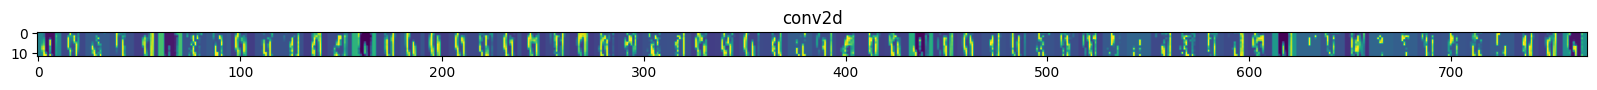

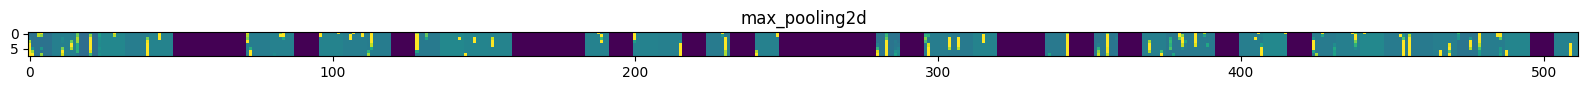

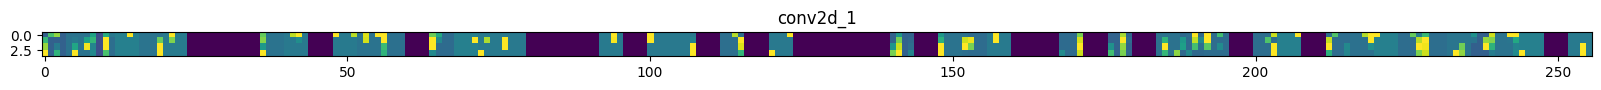

In [45]:
def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip(conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

img_index = 2  
img = x_test_normalized[img_index]
x = np.expand_dims(img, axis=0)

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')